In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web # Not directly used for CSV loading in the provided functions
import datetime as dt 

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='urllib3')

In [3]:
# The crypto currencies we will study
crypto_currency1 = 'BTC'
crypto_currency2 = 'ETH'
crypto_currency3 = 'LTC'
against_currency = 'USD'

# List to store R2 scores
acc = [] 

In [4]:
# Function to create and fit an LSTM model

def create_and_fit__model(x_train, y_train):
  """Creates, compiles, and fits an LSTM model."""
  # Sequential models are a simple way to stack layers one after another.
  model = Sequential()
  # First LSTM layer with Dropout
  # units=50: 50 LSTM cells in the layer
  # return_sequences=True: Output the full sequence to the next LSTM layer
  # input_shape: (number of time steps, number of features per time step)
  model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
  
  # Dropout for regularization
  model.add(Dropout(0.2)) 

  # Second LSTM layer with Dropout
  model.add(LSTM(units=50, return_sequences=True))
  model.add(Dropout(0.2))

  # Third LSTM layer (return_sequences=False by default as it's the last LSTM layer before Dense)
  model.add(LSTM(units=50))
  model.add(Dropout(0.2))
  
  # Dense output layer with 1 unit for predicting a single value (the price)
  model.add(Dense(units=1))

  # Compile the model
  model.compile(optimizer='adam', loss='mean_squared_error')
  
  # Fit the model to the training data
  # epochs=25: The model will iterate over the entire training dataset 25 times
  # batch_size=32: The model's weights will be updated after processing 32 samples
  print("Starting LSTM model training...")
  
  # verbose=1 for progress bar
  model.fit(x_train, y_train, epochs=25, batch_size=32, verbose=1) 
  print("LSTM model training finished.")
  return model

In [5]:

def prediction_function(crypto_currency):
    print(f"\n--- Processing for {crypto_currency} ---")
    
    # The dataset should be read/downloaded from the 1st of Jan, 2018
    start_date = dt.datetime(2018, 1, 1)
    
    # The dataset should be read/downloaded till today
    end_date = dt.datetime.now()

    # --- Training Data Preparation ---
    print("Loading and preprocessing data for training sequences...")
    try:
        df = pd.read_csv('datasets/Preprocess.csv')
    except FileNotFoundError:
        print("Error: 'datasets/Preprocess.csv' not found. Please ensure the file exists.")
        return [0,0] # Return dummy values
        
    # Convert 'Date' column to datetime if it's not already in datetime format
    if 'd' not in df.columns or 'c' not in df.columns or 'v' not in df.columns:
        print("Error: CSV must contain 'd', 'c', and 'v' columns.")
        return [0,0]
        
    df['d'] = pd.to_datetime(df['d'])

    # Filter DataFrame to include only data within the specified date range for training data generation
    df_filtered_for_training_seq = df[(df['d'] >= start_date) & (df['d'] <= end_date)].copy() # Use .copy() to avoid SettingWithCopyWarning
    
    if df_filtered_for_training_seq.empty:
        print(f"No data found for {crypto_currency} in the range {start_date} to {end_date} for training sequence generation.")
        return [0,0]

    # IMPORTANT SCALER NOTE: Ideally, fit scaler ONLY on training portion of 'c'.
    # Current approach fits on 'c' and 'v' from the entire 2018-now range for training sequence generation.
    scaler_train = MinMaxScaler(feature_range=(0, 1))
    # We are only predicting 'c', so ideally scale only 'c'. 
    # If scaling multiple, inverse_transform needs careful handling.
    # For simplicity here, we'll assume the model predicts 'c' and scaler is for 'c'.
    # However, the original code scales 'c' and 'v' together.
    df_scaled_train_features = scaler_train.fit_transform(df_filtered_for_training_seq[['c', 'v']].values) # Original approach
    # Alternative for scaling only 'c':
    # scaler_c_only = MinMaxScaler(feature_range=(0,1))
    # scaled_c_prices_train = scaler_c_only.fit_transform(df_filtered_for_training_seq[['c']].values)

    # Looks back on 60 days of data to predict the values of 61st day
    lookback = 60
    x_train, y_train, vol_feature_unused = [], [], [] # Renamed 'vol' to 'vol_feature_unused'

    # Filling up the x_train and y_train with the scaled data
    # df_scaled_train_features[:, 0] is the scaled 'c' price
    # df_scaled_train_features[:, 1] is the scaled 'v' volume
    for i in range(lookback, len(df_scaled_train_features)):
      # Finding the consolidated Volume for the past lookback days (THIS IS NOT USED BY THE LSTM)
      com_vol = 0
      for j in range(i - lookback, i):
          com_vol += df_scaled_train_features[j, 1] # Accessing scaled volume
      com_vol = com_vol / lookback # Average scaled volume
      vol_feature_unused.append(com_vol)

      # The value of Closing Price for the last 'lookback' days should be used to predict the value of today
      x_train.append(df_scaled_train_features[i - lookback: i, 0]) # Using scaled 'c' price

      # The value of Closing price at i is the required output/label
      y_train.append(df_scaled_train_features[i, 0]) # Using scaled 'c' price

    if not x_train: # Check if x_train is empty (e.g. if df_scaled_train_features length < lookback)
        print(f"Not enough data to create training sequences for {crypto_currency} (need > {lookback} days).")
        return [0,0]
        
    # Converting the data set we have created into a numpy array
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    # vol_feature_unused = np.array(vol_feature_unused) # Not used
    print(f"Number of training sequences created for {crypto_currency}: {len(x_train)}")

    # --- Testing Data Preparation ---
    print("Loading and preprocessing data for testing...")
    test_start = dt.datetime(2021, 1, 1)
    test_end = dt.datetime.now()

    # Reloading the CSV is inefficient, but following original structure
    df_for_test_filtering = pd.read_csv('datasets/Preprocess.csv') 
    df_for_test_filtering['d'] = pd.to_datetime(df_for_test_filtering['d'])
    df_test = df_for_test_filtering[(df_for_test_filtering['d'] >= test_start) & (df_for_test_filtering['d'] <= test_end)].copy()

    if df_test.empty:
        print(f"No test data found for {crypto_currency} in the range {test_start} to {test_end}.")
        return [0,0]
        
    print("First few rows of the filtered test DataFrame:")
    print(df_test.head())
    actual_prices = df_test['c'].values

    # Creating a combined series for model inputs: historical data + test data
    # This should use the 'c' column from the *original full df* before it was filtered for training sequences
    # to get data prior to df_test for lookback period.
    # The original df_total was problematic. Let's try to reconstruct correctly:
    # We need 'c' values from (test_start - lookback days) up to test_end.
    required_start_for_model_inputs = test_start - dt.timedelta(days=lookback + 5) # +5 for buffer
    model_input_data_unscaled = pd.concat([df_for_test_filtering[
        (df_for_test_filtering['d'] >= required_start_for_model_inputs) & 
        (df_for_test_filtering['d'] < test_start) # Data before test set for lookback
    ]['c'], df_test['c']], ignore_index=True) # Append actual test data prices
    
    model_inputs_unscaled_values = model_input_data_unscaled.values.reshape(-1, 1)

    # CRITICAL SCALER ISSUE: Re-fitting scaler here causes data leakage.
    # SHOULD USE THE SCALER FITTED ON TRAINING DATA (e.g., scaler_train or a dedicated scaler_c_only_train)
    # For now, following original logic of re-fitting, but this is incorrect for proper evaluation.
    scaler_test_problematic = MinMaxScaler(feature_range=(0,1))
    model_inputs_scaled = scaler_test_problematic.fit_transform(model_inputs_unscaled_values)
    # Correct approach would be (assuming scaler_c_only_train was fitted on training 'c' prices):
    # model_inputs_scaled = scaler_c_only_train.transform(model_inputs_unscaled_values)

    x_test = []
    # y_test_scaled = [] # Original y_test was created but not used for R2 score

    # Creating test sequences
    # The actual test inputs start after the initial 'lookback' period within model_inputs_scaled
    # The number of test predictions should match len(actual_prices)
    # The loop should go from 'lookback' up to 'lookback + len(actual_prices) -1'
    # to generate len(actual_prices) sequences for x_test.
    # The start of actual test data in model_inputs_scaled is after the initial lookback period used from historical data.
    # Let's find the point where df_test['c'] starts in model_input_data_unscaled
    num_historical_points_for_lookback = len(model_input_data_unscaled) - len(actual_prices)

    for i in range(num_historical_points_for_lookback, len(model_inputs_scaled)):
        if i < lookback: # Should not happen if num_historical_points_for_lookback >= lookback
            continue
        x_test.append(model_inputs_scaled[i - lookback: i, 0])
        # y_test_scaled.append(model_inputs_scaled[i, 0])
        if len(x_test) == len(actual_prices): # Ensure we only create enough x_test for actual_prices
            break

    if not x_test or len(x_test) != len(actual_prices):
        print(f"Error creating test sequences or mismatch with actual prices for {crypto_currency}.")
        print(f"x_test length: {len(x_test)}, actual_prices length: {len(actual_prices)}")
        return [0,0]
        
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    print(f"Number of test sequences created for {crypto_currency}: {len(x_test)}")

    # Reshape x_train for LSTM input
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # --- Model Training and Prediction ---
    model = create_and_fit__model(x_train, y_train)

    print(f"Predicting prices for {crypto_currency} on the test set...")
    prediction_prices_scaled = model.predict(x_test)
    
    # Inverse transform predictions.
    # This should use the scaler that corresponds to how x_test was scaled.
    # Due to re-fitting scaler_test_problematic, we use that here.
    # If only 'c' was scaled, inverse_transform needs a 2D array like (n_samples, 1)
    # If 'c' and 'v' were scaled together by scaler_train, and model predicts only 'c',
    # we'd need to pad prediction_prices_scaled with a dummy 'v' column before inverse_transforming with scaler_train.
    # Given the current problematic scaler_test_problematic was fit on single column 'c' effectively:
    prediction_prices = scaler_test_problematic.inverse_transform(prediction_prices_scaled)

    # --- Evaluation ---
    if len(actual_prices) == len(prediction_prices):
        r2 = r2_score(actual_prices, prediction_prices)
        acc.append(r2)
        print(f"R2 Score for {crypto_currency}: {r2:.4f}")
    else:
        print("Length mismatch between actual and predicted prices. Cannot calculate R2 score.")
        acc.append(np.nan) # Append NaN if score cannot be calculated

    # --- Plotting Test Predictions ---
    plt.figure(figsize=(12,6))
    plt.plot(actual_prices, color='black', label='Actual Prices')
    plt.plot(prediction_prices, color='green', label='Predicted Prices (Test Set)')
    plt.title(f"{crypto_currency} Price Prediction (Test Set)")
    plt.xlabel("Time (Test Set Index)")
    plt.ylabel("Price")
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

    # --- Predict Next 7 Days (Iterative Forecasting) ---
    print(f"Performing 7-day iterative forecast for {crypto_currency}...")
    # Use the last 'lookback' sequence from model_inputs_scaled (which was used to create the last x_test item)
    last_sequence_scaled = model_inputs_scaled[-lookback:].reshape(1, lookback, 1)
    
    future_predictions_scaled = []
    current_sequence_scaled = last_sequence_scaled.copy()

    for _ in range(7):
        next_pred_scaled = model.predict(current_sequence_scaled)
        future_predictions_scaled.append(next_pred_scaled[0,0])
        # Update the sequence: remove the oldest value, append the new prediction
        current_sequence_scaled = np.append(current_sequence_scaled[:, 1:, :], next_pred_scaled.reshape(1, 1, 1), axis=1)

    future_predictions_scaled = np.array(future_predictions_scaled).reshape(-1,1)
    # Inverse transform using the same scaler as for test predictions (scaler_test_problematic)
    future_predictions_unscaled = scaler_test_problematic.inverse_transform(future_predictions_scaled)

    # Combine test predictions with 7-day forecast for plotting
    full_predicted_path = np.concatenate((prediction_prices, future_predictions_unscaled))
    
    # Create an extended index for plotting the 7-day forecast
    plot_index_actual = np.arange(len(actual_prices))
    plot_index_full_pred = np.arange(len(full_predicted_path))

    plt.figure(figsize=(12,6))
    plt.plot(plot_index_actual, actual_prices, color='black', label='Actual Prices (Test Set)')
    plt.plot(plot_index_full_pred, full_predicted_path, color='red', linestyle='--', label='Predicted Prices + 7-Day Forecast')
    plt.axvline(x=len(actual_prices)-1, color='gray', linestyle=':', label='End of Actual Test Data')
    plt.title(f"{crypto_currency} Price Prediction with 7-Day Forecast")
    plt.xlabel("Time (Index)")
    plt.ylabel("Price")
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

    # --- Upside/Downside Calculation for the 7-day forecast ---
    if len(actual_prices) > 0 and len(prediction_prices) > 0 and len(future_predictions_unscaled) > 0:
        # price_today_actual = actual_prices[-1] # Last actual price from test set
        # Using the model's prediction for the last day of test set as baseline for 7-day forecast potential
        pred_price_last_day_of_test = prediction_prices[-1,0]

        max_future_price = np.max(future_predictions_unscaled)
        min_future_price = np.min(future_predictions_unscaled)

        upside = ((max_future_price - pred_price_last_day_of_test) * 100) / pred_price_last_day_of_test if pred_price_last_day_of_test != 0 else 0
        downside = ((min_future_price - pred_price_last_day_of_test) * 100) / pred_price_last_day_of_test if pred_price_last_day_of_test != 0 else 0
        print(f"Calculated 7-day forecast for {crypto_currency}: Upside={upside:.2f}%, Downside={downside:.2f}%")
        return [upside, downside]
    else:
        print(f"Could not calculate upside/downside for {crypto_currency} due to insufficient data.")
        return [0, 0] # Default if calculation fails

print("Setup complete. Ready to run predictions.")

Setup complete. Ready to run predictions.



--- Processing for BTC ---
Loading and preprocessing data for training sequences...
Number of training sequences created for BTC: 1548
Loading and preprocessing data for testing...
First few rows of the filtered test DataFrame:
             d         o         h         l         c        v
481 2021-01-01  29326.55  29350.00  29326.55  29337.16   81.585
482 2021-01-02  32208.71  32222.00  32172.18  32199.91  291.592
483 2021-01-03  32984.17  33077.34  32965.54  33054.53  535.856
484 2021-01-04  32049.71  32068.00  32022.56  32031.07  251.813
485 2021-01-05  33944.26  34016.13  33937.37  33999.52  141.828
Number of test sequences created for BTC: 1127
Starting LSTM model training...
Epoch 1/25


/Users/daine/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0647
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0056
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0046
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0038
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0040
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0036
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0032
Epoch 8/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0038
Epoch 9/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0034
Epoch 10/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0030
Epoch 11/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0032
Epoch 12/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0030
Epoch 13/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0034
Epoch 14/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0028
Epoch 15/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0029
Epoch 16/25
49/

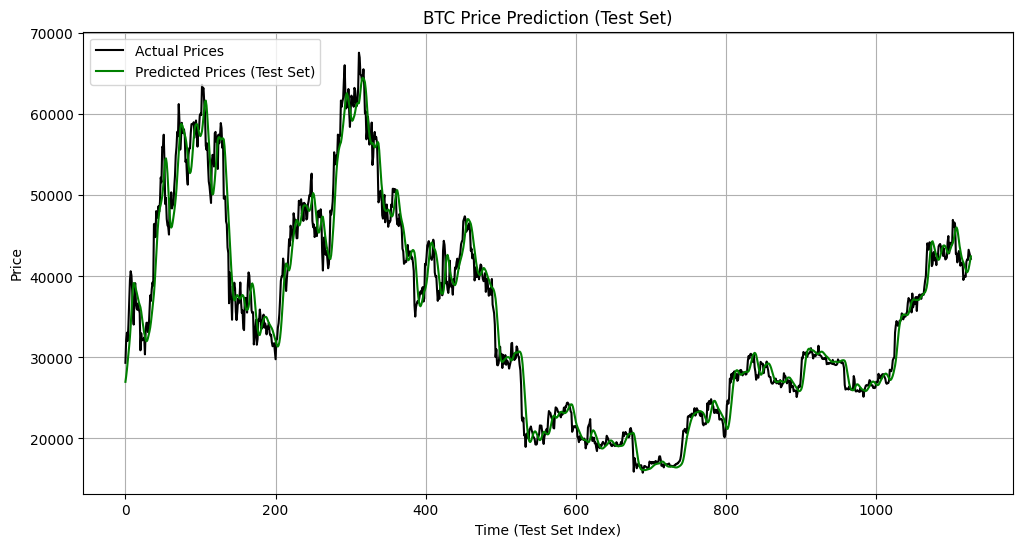

Performing 7-day iterative forecast for BTC...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


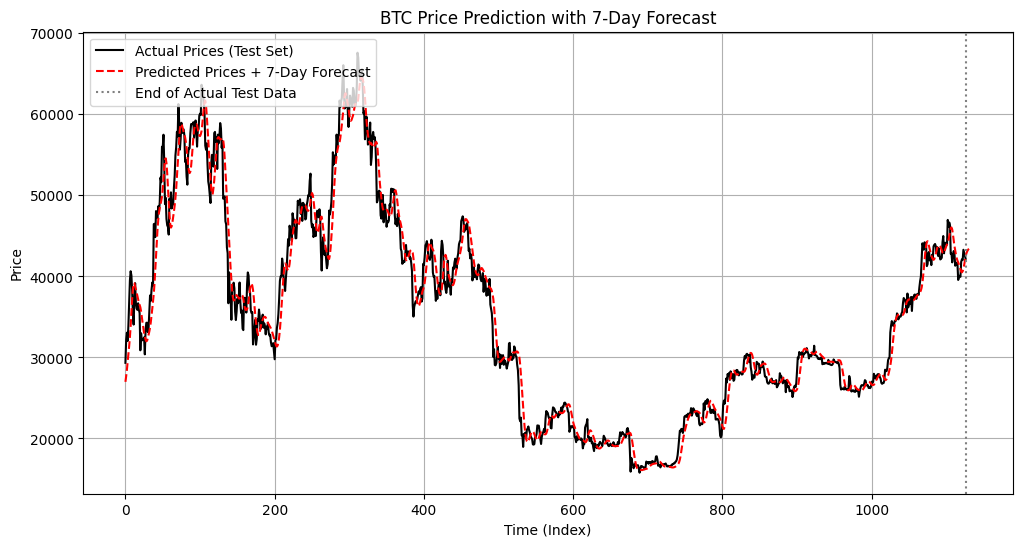

Calculated 7-day forecast for BTC: Upside=2.68%, Downside=0.86%

--- Processing for ETH ---
Loading and preprocessing data for training sequences...
Number of training sequences created for ETH: 1548
Loading and preprocessing data for testing...
First few rows of the filtered test DataFrame:
             d         o         h         l         c        v
481 2021-01-01  29326.55  29350.00  29326.55  29337.16   81.585
482 2021-01-02  32208.71  32222.00  32172.18  32199.91  291.592
483 2021-01-03  32984.17  33077.34  32965.54  33054.53  535.856
484 2021-01-04  32049.71  32068.00  32022.56  32031.07  251.813
485 2021-01-05  33944.26  34016.13  33937.37  33999.52  141.828
Number of test sequences created for ETH: 1127
Starting LSTM model training...
Epoch 1/25


/Users/daine/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0486
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0055
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0049
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0040
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0039
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0039
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0032
Epoch 8/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0036
Epoch 9/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0031
Epoch 10/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0035
Epoch 11/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0029
Epoch 12/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0028
Epoch 13/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0031
Epoch 14/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0028
Epoch 15/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0025
Epoch 16/25
49/

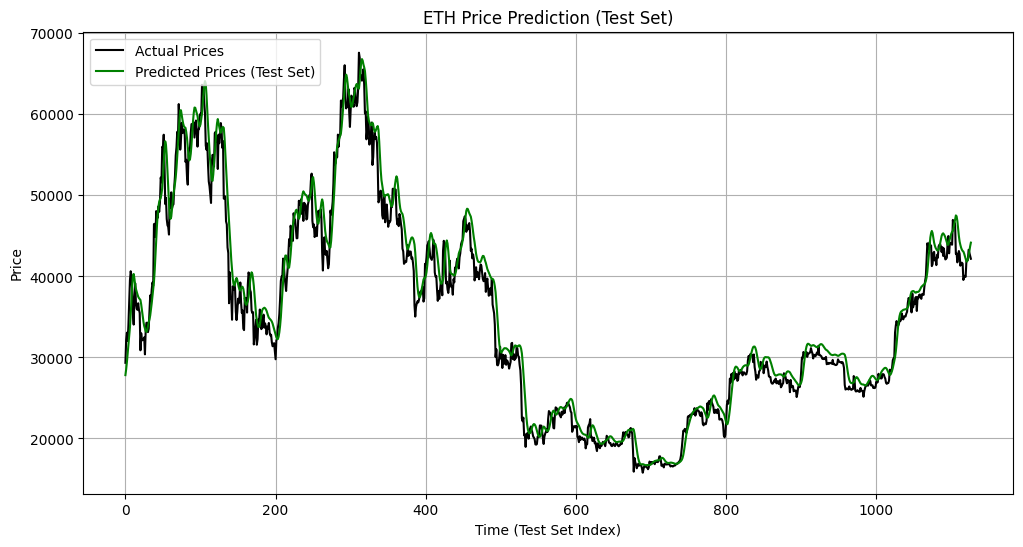

Performing 7-day iterative forecast for ETH...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


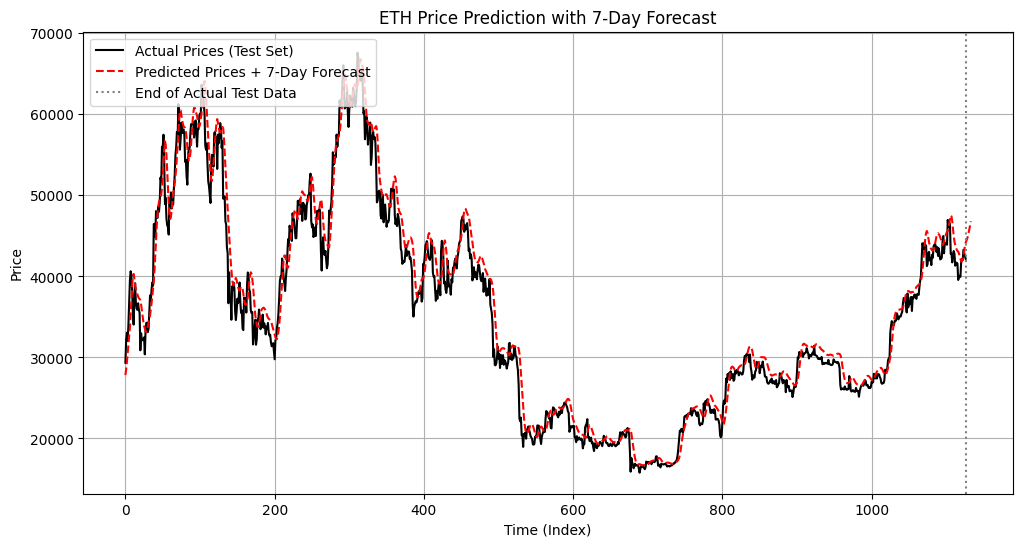

Calculated 7-day forecast for ETH: Upside=5.95%, Downside=0.49%

--- Processing for LTC ---
Loading and preprocessing data for training sequences...
Number of training sequences created for LTC: 1548
Loading and preprocessing data for testing...
First few rows of the filtered test DataFrame:
             d         o         h         l         c        v
481 2021-01-01  29326.55  29350.00  29326.55  29337.16   81.585
482 2021-01-02  32208.71  32222.00  32172.18  32199.91  291.592
483 2021-01-03  32984.17  33077.34  32965.54  33054.53  535.856
484 2021-01-04  32049.71  32068.00  32022.56  32031.07  251.813
485 2021-01-05  33944.26  34016.13  33937.37  33999.52  141.828
Number of test sequences created for LTC: 1127
Starting LSTM model training...
Epoch 1/25


/Users/daine/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0399
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0046
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0051
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0043
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0036
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0036
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0035
Epoch 8/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0030
Epoch 9/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0034
Epoch 10/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0028
Epoch 11/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0031
Epoch 12/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0037
Epoch 13/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0028
Epoch 14/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0027
Epoch 15/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0026
Epoch 16/25
49/

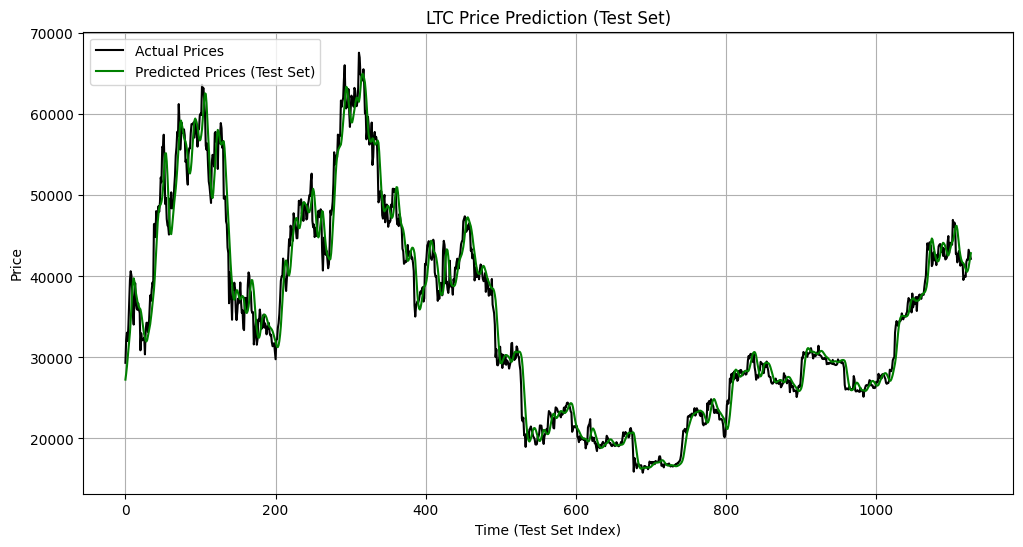

Performing 7-day iterative forecast for LTC...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


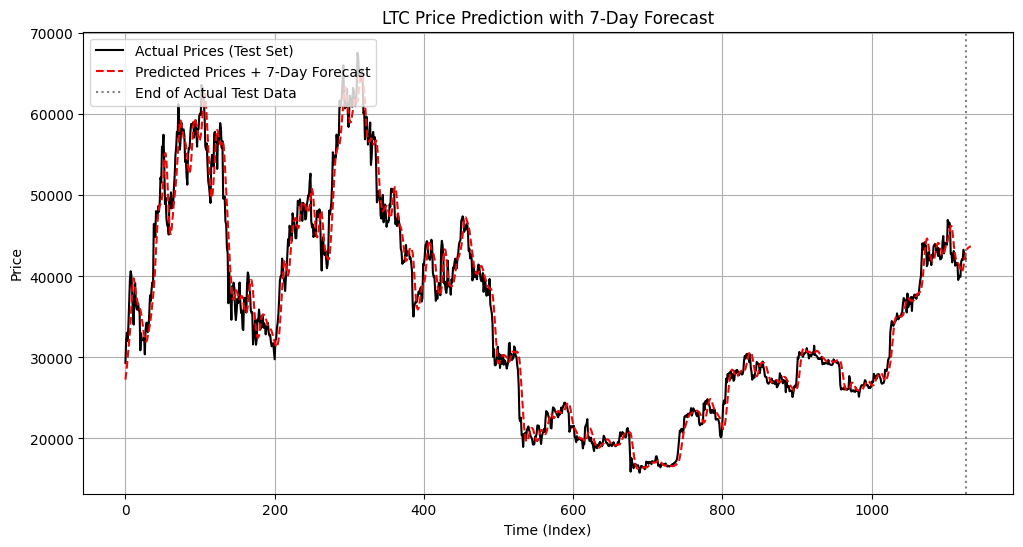

Calculated 7-day forecast for LTC: Upside=2.03%, Downside=0.76%


In [6]:
# Call the `prediction_function` for each specified cryptocurrency. The R2 scores will be stored in the `acc` list, and the predicted upside/downside for the 7-day forecast will be stored in `sides1`, `sides2`, `sides3`.

sides1 = prediction_function(crypto_currency1) # BTC
sides2 = prediction_function(crypto_currency2) # ETH
sides3 = prediction_function(crypto_currency3) # LTC

In [7]:
if len(acc) == 3:
    print("\n--- R2 Accuracy Scores ---")
    print(f"The R2 accuracy score for {crypto_currency1} = {acc[0]*100 if not np.isnan(acc[0]) else 'N/A'} %")
    print(f"The R2 accuracy score for {crypto_currency2} = {acc[1]*100 if not np.isnan(acc[1]) else 'N/A'} %")
    print(f"The R2 accuracy score for {crypto_currency3} = {acc[2]*100 if not np.isnan(acc[2]) else 'N/A'} %")

    valid_acc_scores = [s for s in acc if not np.isnan(s)]
    if len(valid_acc_scores) > 0:
        average_r2 = (sum(valid_acc_scores) / len(valid_acc_scores)) * 100
        print(f"Average R2 accuracy score (of valid scores) = {average_r2:.2f} %")
    else:
        print("No valid R2 scores to calculate an average.")
else:
    print("\nAccuracy scores were not calculated for all cryptocurrencies, possibly due to errors or insufficient data.")
    print(f"Collected R2 scores: {acc}")


--- R2 Accuracy Scores ---
The R2 accuracy score for BTC = 96.77388320098903 %
The R2 accuracy score for ETH = 96.49968981047124 %
The R2 accuracy score for LTC = 97.09575138495401 %
Average R2 accuracy score (of valid scores) = 96.79 %


In [8]:
# ## 6. Investment Allocation Suggestion
# 
# This section takes a user-provided investment amount and suggests an allocation based on the predicted positive upsides from the 7-day forecast. 
# 
# - If all predicted upsides are zero or negative, it advises against investing.
# - Otherwise, it allocates the amount proportionally to the positive upsides and estimates the portfolio's overall potential upside and downside.
# 
# **Disclaimer:** This is a simplistic allocation strategy based purely on the model's short-term forecast. It does not consider risk diversification, market conditions, or other crucial investment factors. The reliability of this advice is entirely dependent on the (potentially flawed, due to scaling) accuracy of the underlying prediction model. **This is not financial advice.**


try:
    amount_input = input("Enter the total amount you want to invest: ")
    amount = np.float64(amount_input)
except ValueError:
    print("Invalid amount entered. Please enter a numeric value.")
    amount = 0.0 # Default to 0 if input is invalid

if amount > 0 and sides1 and sides2 and sides3: # Ensure sides are not None or empty
    # Adjust negative predicted upsides to 0, as we wouldn't invest for a predicted loss in this scheme
    s1_upside = max(0, sides1[0])
    s2_upside = max(0, sides2[0])
    s3_upside = max(0, sides3[0])

    s1_downside = sides1[1]
    s2_downside = sides2[1]
    s3_downside = sides3[1]

    total_positive_upside_factor = s1_upside + s2_upside + s3_upside

    if total_positive_upside_factor == 0:
        # Sum of negative downsides (larger negative is more loss)
        total_potential_loss_sum = s1_downside + s2_downside + s3_downside 
        print(f"This might not be the right time to invest! All cryptocurrencies have zero or negative predicted 7-day upside. \nIf investing blindly, the sum of individual predicted downsides is: {total_potential_loss_sum:.2f}% (This is a simple sum, not a portfolio downside).")
    else:
      # Calculate shares based on proportion of positive upsides
      BTC_share_val = amount * (s1_upside / total_positive_upside_factor)
      ETH_share_val = amount * (s2_upside / total_positive_upside_factor)
      LTC_share_val = amount * (s3_upside / total_positive_upside_factor)

      # Calculate absolute upside/downside for each allocated share
      BTC_abs_upside = (BTC_share_val * s1_upside) / 100
      BTC_abs_downside = (BTC_share_val * s1_downside) / 100

      ETH_abs_upside = (ETH_share_val * s2_upside) / 100
      ETH_abs_downside = (ETH_share_val * s2_downside) / 100

      LTC_abs_upside = (LTC_share_val * s3_upside) / 100
      LTC_abs_downside = (LTC_share_val * s3_downside) / 100

      # Calculate total portfolio upside/downside amounts
      portfolio_total_abs_upside = BTC_abs_upside + ETH_abs_upside + LTC_abs_upside
      portfolio_total_abs_downside = BTC_abs_downside + ETH_abs_downside + LTC_abs_downside

      # Calculate overall portfolio upside/downside percentages
      portfolio_upside_pct = (portfolio_total_abs_upside / amount) * 100 if amount > 0 else 0
      portfolio_downside_pct = (portfolio_total_abs_downside / amount) * 100 if amount > 0 else 0

      print("\n--- Investment Allocation Suggestion (Based on Model's 7-Day Forecast Upside) ---")
      print(f"You could consider investing:")
      print(f" {against_currency} {BTC_share_val:.2f} in {crypto_currency1}")
      print(f" {against_currency} {ETH_share_val:.2f} in {crypto_currency2}")
      print(f" {against_currency} {LTC_share_val:.2f} in {crypto_currency3}")
      print(f"\nEstimated Portfolio Potential (based on model forecasts):")
      print(f"  Overall Upside: {portfolio_upside_pct:.2f}% (Absolute: {against_currency} {portfolio_total_abs_upside:.2f})")
      print(f"  Overall Downside: {portfolio_downside_pct:.2f}% (Absolute: {against_currency} {portfolio_total_abs_downside:.2f})")
      print("\nDisclaimer: This is a simplistic suggestion based on model predictions and not financial advice. Invest at your own risk.")
elif amount <= 0:
    print("No investment amount entered or amount is zero. No allocation suggestion provided.")
else:
    print("Could not generate investment advice. 'sides' variables might not be properly populated due to earlier errors.")



--- Investment Allocation Suggestion (Based on Model's 7-Day Forecast Upside) ---
You could consider investing:
 USD 1256.57 in BTC
 USD 2791.40 in ETH
 USD 952.02 in LTC

Estimated Portfolio Potential (based on model forecasts):
  Overall Upside: 4.38% (Absolute: USD 219.23)
  Overall Downside: 0.63% (Absolute: USD 31.72)

Disclaimer: This is a simplistic suggestion based on model predictions and not financial advice. Invest at your own risk.
